<a href="https://colab.research.google.com/github/jkakos/EmployeeTurnover/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Salifort Motors Employee Retention

This work was done for the Google Advanced Data Analytics course capstone project. The dataset contains the results of an employee survey from a fictional company, Salifort Motors, that is looking to reduce their employee turnover. The goal is to make a model that predicts which employees may leave the company and use it to uncover reasons causing employees to leave.

In [ ]:
# !pip install scikit-learn==1.3.1

In [ ]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics as metrics
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from xgboost import plot_importance, XGBClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# First look at the data

In [ ]:
root = pathlib.Path("./drive/MyDrive/Colab Notebooks/employee_turnover/")
df0 = pd.read_csv(root.joinpath('HR_Salifort_dataset.csv'))
df0.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


The column names are inconsistent in their formatting so we'll clean them up.

In [ ]:
df0 = df0.rename(
    {
        'satisfaction_level': 'satisfaction',
        'number_project': 'num_projects',
        'average_montly_hours': 'average_monthly_hours',
        'time_spend_company': 'years_at_company',
        'Work_accident': 'work_accident',
        'Department': 'department'
    },
    axis=1
)

In [ ]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction           14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   num_projects           14999 non-null  int64  
 3   average_monthly_hours  14999 non-null  int64  
 4   years_at_company       14999 non-null  int64  
 5   work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


## Columns available

| Column | dtype | Description |
| ------ | ----- | ----------- |
| satisfaction | float | The employee’s self-reported satisfaction level [0-1] |
| last_evaluation | float | Score of employee's last performance review [0–1] |
| num_projects | int | Number of projects employee contributes to |
| average_monthly_hours | int | Average number of hours employee worked per month |
| years_at_company | int | How long the employee has been with the company (years) |
| work_accident | int | Whether or not the employee experienced an accident while at work |
| left | int | Whether or not the employee left the company |
| promotion_last_5years | int | Whether or not the employee was promoted in the last 5 years |
| department | str | The employee's department |
| salary | str | The employee's salary (low, medium, or high) |

In [ ]:
df0.describe(include='all')

,satisfaction,last_evaluation,num_projects,average_monthly_hours,years_at_company,work_accident,left,promotion_last_5years,department,salary
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999,14999
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,3
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sales,low
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4140,7316
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268,NaN,NaN
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281,NaN,NaN
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000,NaN,NaN
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000,NaN,NaN
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000,NaN,NaN
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000,NaN,NaN


Check for missing values

In [ ]:
df0.isna().sum()

,0
satisfaction,0
last_evaluation,0
num_projects,0
average_monthly_hours,0
years_at_company,0
work_accident,0
left,0
promotion_last_5years,0
department,0
salary,0


Check for duplicate rows

In [ ]:
df0.duplicated().sum()

3008

There are 3000 duplicate rows in the dataset. Given the number of columns and numeric values, it seems unlikely that repeats would occur naturally, so we'll drop them.

In [ ]:
df1 = df0.drop_duplicates()
df1.describe()

,satisfaction,last_evaluation,num_projects,average_monthly_hours,years_at_company,work_accident,left,promotion_last_5years
count,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000
mean,0.629658,0.716683,3.802852,200.473522,3.364857,0.154282,0.166041,0.016929
std,0.241070,0.168343,1.163238,48.727813,1.330240,0.361234,0.372133,0.129012
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.480000,0.570000,3.000000,157.000000,3.000000,0.000000,0.000000,0.000000
50%,0.660000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.860000,5.000000,243.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


# Data Visualizations

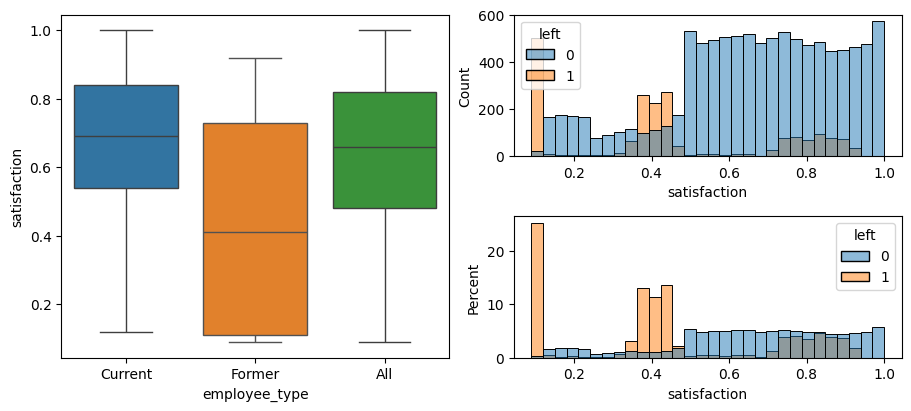

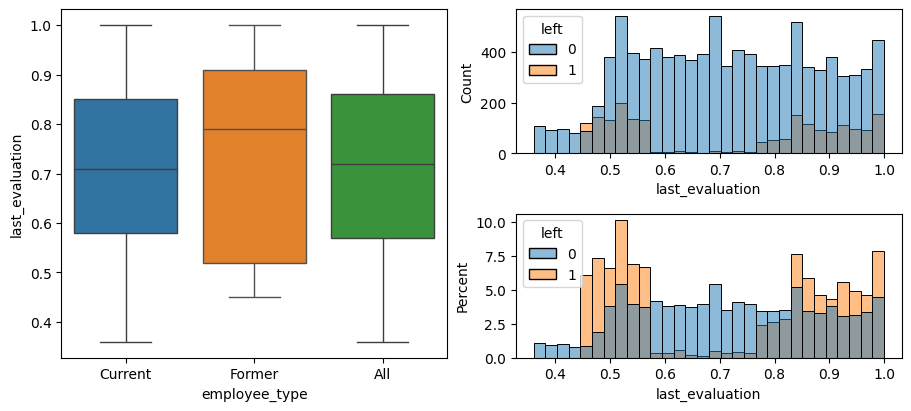

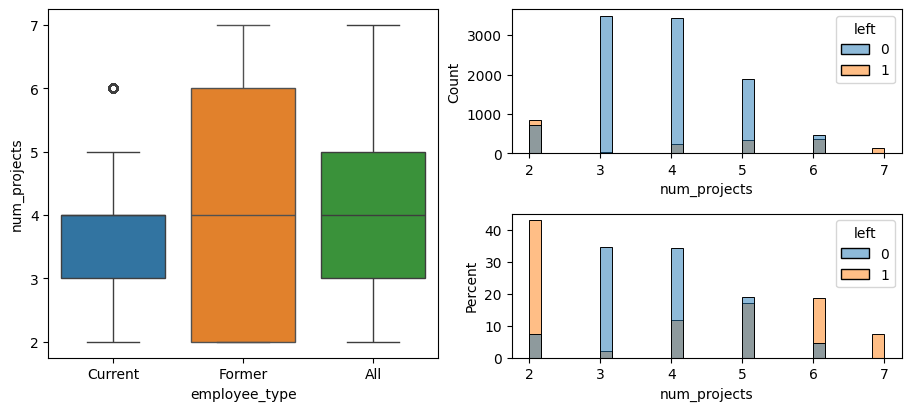

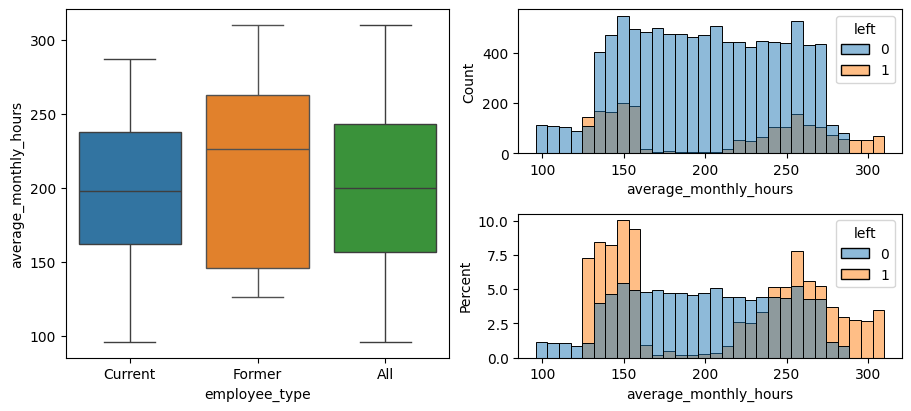

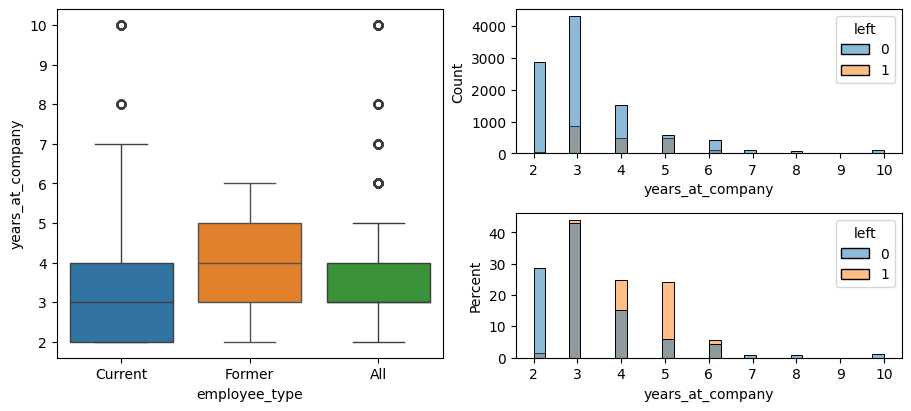

In [ ]:
left = df1['left'].astype(bool)  # filter employees who left the company
plot_cols = ['satisfaction', 'last_evaluation', 'num_projects', 'average_monthly_hours', 'years_at_company']

for i, col in enumerate(plot_cols):
    fig = plt.figure(figsize=(9, 4), constrained_layout=True)
    gs = fig.add_gridspec(2, 2)
    ax0 = fig.add_subplot(gs[:, 0])
    ax1 = fig.add_subplot(gs[0, 1])
    ax2 = fig.add_subplot(gs[1, 1], sharex=ax1)

    sns.boxplot(data=df1[~left].assign(employee_type='Current'), x='employee_type', y=col, ax=ax0)
    sns.boxplot(data=df1[left].assign(employee_type='Former'), x='employee_type', y=col, ax=ax0)
    sns.boxplot(data=df1.assign(employee_type='All'), x='employee_type', y=col, ax=ax0)
    sns.histplot(data=df1, x=col, bins=30, hue='left', ax=ax1)
    sns.histplot(data=df1, x=col, bins=30, hue='left', stat='percent', common_norm=False, ax=ax2)

plt.show()

There are clear distinctions in the distributions of current employees and employees who have left.

* `satisfaction`
    * Employee satisfaction is roughly uniformly distributed separately above and below 0.5 for current employees, with satisfaction above 0.5 being about twice as likely as satisfaction below 0.5.
    * Employee satisfaction is broken into three section for former employees: ~25% with very low satisfaction near 0.1, ~40% around 0.4, and most of the remaining employees near 0.8.

* `last_evaluation`
    * Current employees have roughly a uniform distribution above 0.5.
    * Former employees are bimodal with a group near 0.5 and a separate group around 0.9.
* `num_projects`
    * About 42% of employees who left worked on only 2 projects.
    * As the number of projects increases above 2, the relative fraction of employees who have left the company also increases.
    * All employees working 7 projects left the company.

* `average_monthly_hours`
    * The distribution is similar to `last_evaluation`, but current employees drop off around 275 hours. Almost every employee working more hours than this left the company.
    * Former employees are again bimodal, either working on the low end or the high end of monthly hours.

* `years_at_company`
    * Most of the current employees have been at the company for 2-4 years.
    * The few employees who have been with the company for 7+ years are still with the company.
    * Almost all employees who left the company stayed at least 2 years.
    * About 43% of employees who left the company did so in their 3rd year. About 50% did so in years 4 and 5.

There are signs of different demographics when it comes to employees who leave the company. There are some employees who are satisfied with their job, some who are fairly unsatisfied, and some who are very unsatisfied. Among these, there are those who received good reviews and those who received relatively poor reviews. There are also those who had minimal responsibilities, working only 2 projects and fewer hours, while a significant number of them were working 5+ projects and many more hours.

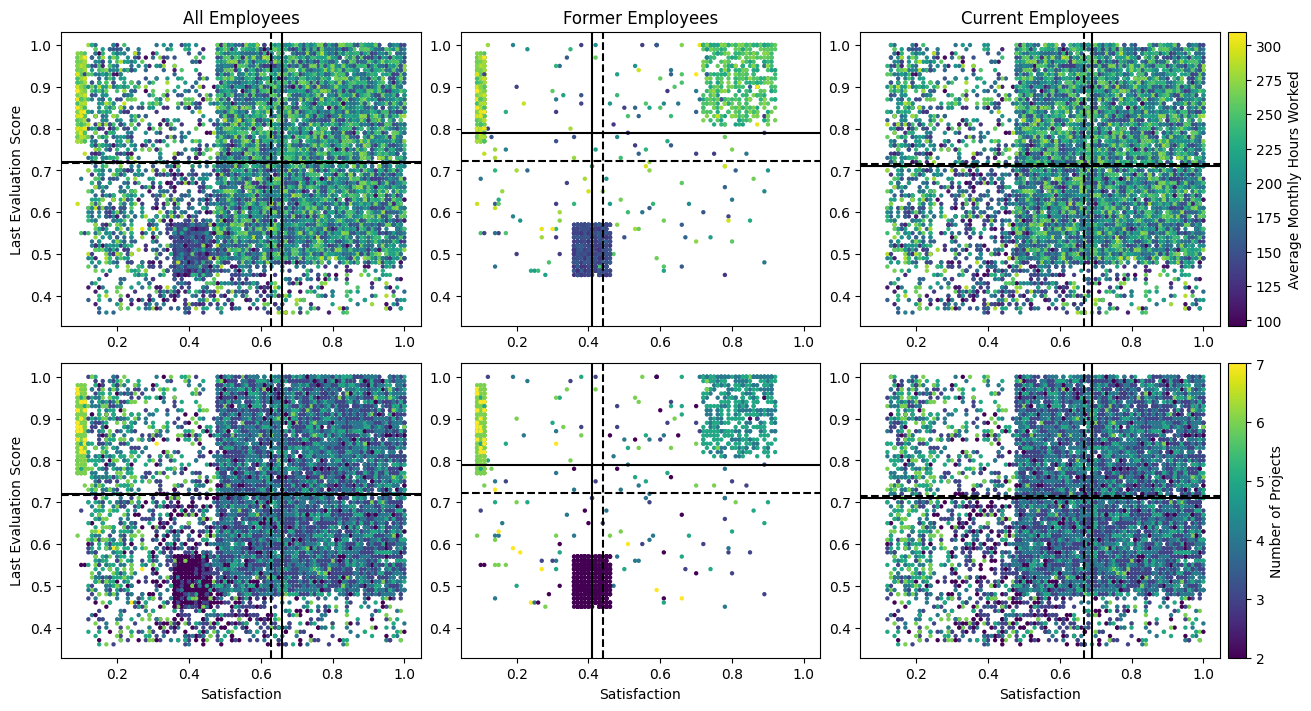

In [ ]:
plot_order = [np.ones(len(df1), dtype=bool), left, ~left]

gridspec = {'width_ratios': [1, 1, 1, 0.05]}
nrows = 2
ncols = len(plot_order) + 1
fig, ax = plt.subplots(figsize=(13, 7), nrows=2, ncols=4, gridspec_kw=gridspec, constrained_layout=True)

# create shared x and y axes
for row in range(nrows):
    for col in range(1, ncols - 1):
        ax[row, col].sharex(ax[row, 0])
        ax[row, col].sharey(ax[row, 0])

for i, subset in enumerate(plot_order):
    df_subset = df1[subset]
    x = df_subset['satisfaction']
    y0 = df_subset['last_evaluation']
    y1 = df_subset['last_evaluation']

    # set color on first iteration to keep it the same across subplots
    if i == 0:
        c0 = df_subset['average_monthly_hours']
        c1 = df_subset['num_projects']

    sc0 = ax[0, i].scatter(x, y0, s=10, edgecolor='none', c=c0[subset], vmin=min(c0), vmax=max(c0))
    sc1 = ax[1, i].scatter(x, y1, s=10, edgecolor='none', c=c1[subset], vmin=min(c1), vmax=max(c1))

    if i == 0:
        fig.colorbar(sc0, cax=ax[0, -1], label='Average Monthly Hours Worked')
        fig.colorbar(sc1, cax=ax[1, -1], label='Number of Projects')

    for j, y in enumerate([y0, y1]):
        ax[j, i].axhline(y=y.median(), color='k')
        ax[j, i].axvline(x=x.median(), color='k')
        ax[j, i].axhline(y=y.mean(), color='k', ls='--')
        ax[j, i].axvline(x=x.mean(), color='k', ls='--')

ax[0, 0].set(ylabel='Last Evaluation Score', title='All Employees')
ax[0, 1].set(title='Former Employees')
ax[0, 2].set(title='Current Employees')
ax[1, 0].set(xlabel='Satisfaction', ylabel='Last Evaluation Score')
ax[1, 1].set(xlabel='Satisfaction')
ax[1, 2].set(xlabel='Satisfaction')
plt.show()

There are three clusters in the distribution of former employees.
1. The upper left shows employees who performed well but were overall very unsatisfied with their job. They worked many hours across many projects. Being overworked likely led to them leaving the company.
2. The upper right shows employees who performed well and were satisfied with their job. They still work an above-average number of projects and hours, however. It's possible these people also felt overworked and left for other opportunities.
3. The lower middle shows employees who had subpar evaluations and were also relatively unsatisfied with their jobs. They worked minimal projects and hours. It's possible these people were given reduced responsibilities and hours due to lack of performance and were ultimately fired.

Check the balance of current and former employees

In [ ]:
pd.concat([df1['left'].value_counts(), df1['left'].value_counts(normalize=True)], axis=1).reset_index()

,left,count,proportion
0,0,10000,0.833959
1,1,1991,0.166041


Handle outliers for logistic regression

In [ ]:
iqr = df1['years_at_company'].quantile(0.75) - df1['years_at_company'].quantile(0.25)
upper_lim = 1.5 * iqr + df1['years_at_company']
outliers = df1['years_at_company'] > upper_lim
df1.loc[:, 'years_at_company_no_outliers'] = df1.loc[:, 'years_at_company']
df1.loc[outliers, 'years_at_company_no_outliers'] = upper_lim
(df1['years_at_company_no_outliers'] > upper_lim).sum()

<ipython-input-287-ddafdae3606e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.loc[:, 'years_at_company_no_outliers'] = df1.loc[:, 'years_at_company']


0

Since higher salary is generally better than lower salary, we can convert `salary` to an ordinal value.

In [ ]:
df1['salary'].unique()

array(['low', 'medium', 'high'], dtype=object)

In [ ]:
salary = df1['salary'].map({'low': 0, 'medium': 1, 'high': 2})
df1.loc[:, 'salary'] = df1.loc[:, 'salary'].map({'low': 0, 'medium': 1, 'high': 2})
df1 = df1.drop('salary', axis=1)
df1['salary'] = salary

In [ ]:
def leave_rate_by_group(df: pd.DataFrame, groupby: str) -> pd.DataFrame:
    """
    Calculate the leave rate and error within a group.

    """
    df1 = df.groupby(groupby).agg(
        num_employees=pd.NamedAgg(column='left', aggfunc='size'),
        leave_rate=pd.NamedAgg(column='left', aggfunc='mean'),
    ).reset_index()
    df1['err'] = np.sqrt(df1['leave_rate'] * (1 - df1['leave_rate']) / df1['num_employees'])
    return df1

def plot_leave_rate_by_group(df: pd.DataFrame, col: str, xlabel: str) -> None:
    """
    Plot a line graph of the leave rate as a function of some column.

    """
    fig, ax = plt.subplots(figsize=(6, 3), constrained_layout=True)
    ax.errorbar(df[col], df['leave_rate'], yerr=df['err'])
    ax.fill_between(df[col], df['leave_rate']-df['err'], df['leave_rate']+df['err'], alpha=0.2)
    ax.set(xlabel=xlabel, ylabel='Fraction of Employees Who Left', ylim=(-0.05, 1.05))

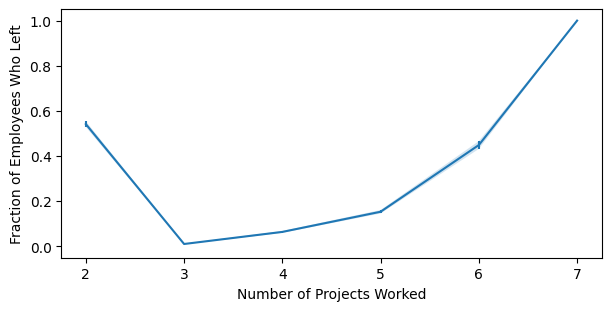

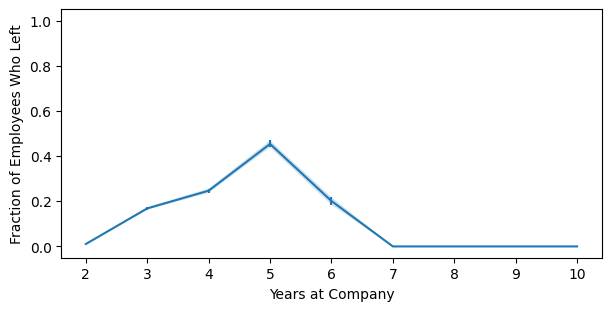

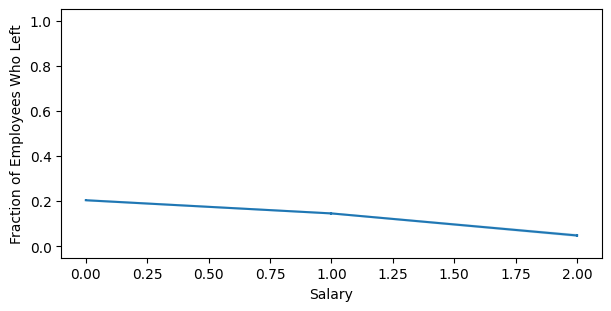

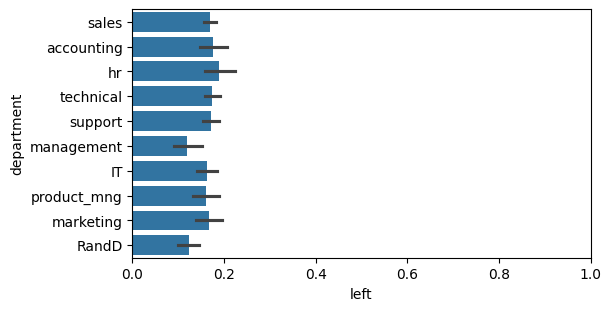

In [ ]:
plot_leave_rate_by_group(
    leave_rate_by_group(df1, 'num_projects'),
    'num_projects',
    'Number of Projects Worked',
)
plot_leave_rate_by_group(
    leave_rate_by_group(df1, 'years_at_company'),
    'years_at_company',
    'Years at Company',
)
plot_leave_rate_by_group(
    leave_rate_by_group(df1, 'salary'),
    'salary',
    'Salary',
)

fig, ax = plt.subplots(figsize=(6, 3), constrained_layout=True)
sns.barplot(x=df1['left'], y=df1['department'], ax=ax)
ax.set(xlim=(0, 1))
plt.show()

* For employees working the minimum number of projects, the turnover rate is fairly balanced. For employees working 3 or more projects, the turnover rate begins to increase substantially.

* The turnover rate peaks at 5 years after joining the company. New employees and long-time employees are less likely to leave.

* Employees with higher salary are less likely to leave.

* The turnover rate does not seem to depend strongly on which department the employee is in.

In [ ]:
df1.groupby('salary')[['satisfaction', 'left']].agg(
    mean_satisfaction=pd.NamedAgg(column='satisfaction', aggfunc='mean'),
    percent_left=pd.NamedAgg(column='left', aggfunc='mean'),
    num_employees=pd.NamedAgg(column='satisfaction', aggfunc='size'),
).reset_index()

,salary,mean_satisfaction,percent_left,num_employees
0,0,0.622655,0.204530,5740
1,1,0.634723,0.146170,5261
2,2,0.643343,0.048485,990


Satisfaction is fairly consistent across different salaries, but employees with lower salaries are more likely to leave.

In [ ]:
tab = df1.groupby('work_accident').agg(
    num_employees=pd.NamedAgg(column='left', aggfunc='size'),
    num_left=pd.NamedAgg(column='left', aggfunc='sum'),
    leave_rate=pd.NamedAgg(column='left', aggfunc='mean'),
).reset_index()

tab

,work_accident,num_employees,num_left,leave_rate
0,0,10141,1886,0.185978
1,1,1850,105,0.056757


Employees involved in a work accident were much less likely to leave the company.

# Summary of Data

* Employees who left generally fall into one of three categories.
    1. Employees that worked a lot of projects, a lot of hours, received positive evaluations, and were overall unsatisfied with their job
    2. Employees that worked an above-average number of projects and hours (though, fewer than type 1 employees), received positive evaluations, and were overall satisfied with their job
    3. Employees who worked a minimal number of projects and hours, had poor evaluations, and were relatively unsatisfied with their job

* For employees working the minimum number of projects, the turnover rate is fairly balanced. For employees working 3 or more projects, the turnover rate increases substantially with the number of projects.

* The turnover rate peaks at 5 years after joining the company. New employees and long-time employees are less likely to leave.

* Employees with higher salary are less likely to leave.

* The turnover rate does not seem to depend on which department the employee is in.

# Build a Model

Since employee satisfaction comes from a sample survey of employees, we will assume that it won't necessarily be available for all employees when using a model.

In [ ]:
X = df1.drop(['left', 'satisfaction', 'years_at_company'], axis=1)
y = df1['left']

X = pd.get_dummies(X, columns=['department'], dtype=int)

X_train_, X_test, y_train_, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=12)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_, y_train_, test_size=0.25, stratify=y_train_, random_state=12
)

In [ ]:
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
refit = 'f1'

## Logistic Regression

In [ ]:
lr_cv = LogisticRegressionCV(
    Cs=5, scoring='f1', cv=5, class_weight='balanced', refit=True, max_iter=500, n_jobs=-1, random_state=12
)

In [ ]:
%%time
lr_cv.fit(X_train, y_train)

CPU times: user 90.2 ms, sys: 86.4 ms, total: 177 ms
Wall time: 2.28 s


LogisticRegressionCV(Cs=5, class_weight='balanced', cv=5, max_iter=500,
                     n_jobs=-1, random_state=12, scoring='f1')

## Decision Tree

In [ ]:
dt = DecisionTreeClassifier(random_state=12)

In [ ]:
dt_params = {
    'max_depth': [3, 5, None],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 3],
}
dt_cv = GridSearchCV(dt, param_grid=dt_params, scoring=scoring, cv=5, refit=refit, n_jobs=-1)

In [ ]:
%%time
dt_cv.fit(X_train, y_train)

CPU times: user 166 ms, sys: 51.6 ms, total: 218 ms
Wall time: 2.08 s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=12), n_jobs=-1,
             param_grid={'max_depth': [3, 5, None], 'min_samples_leaf': [1, 3],
                         'min_samples_split': [2, 4]},
             refit='f1',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [ ]:
print(dt_cv.best_params_)
print(dt_cv.best_score_)

{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
0.8985663662831087


## Random Forest

In [ ]:
rf = RandomForestClassifier(random_state=12)

In [ ]:
rf_params = {
    'n_estimators': [300, 500],
    'max_depth': [3, 5, None],
    'max_features': [1, 2],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 3],
}
rf_cv = GridSearchCV(rf, param_grid=rf_params, scoring=scoring, cv=5, refit=refit, n_jobs=-1)

In [ ]:
%%time
rf_cv.fit(X_train, y_train)

CPU times: user 5.32 s, sys: 704 ms, total: 6.02 s
Wall time: 5min


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=12), n_jobs=-1,
             param_grid={'max_depth': [3, 5, None], 'max_features': [1, 2],
                         'min_samples_leaf': [1, 3],
                         'min_samples_split': [2, 4],
                         'n_estimators': [300, 500]},
             refit='f1',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [ ]:
print(rf_cv.best_params_)
print(rf_cv.best_score_)

{'max_depth': None, 'max_features': 2, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 300}
0.8941934456558126


## XGBoost

In [ ]:
xgb = XGBClassifier(random_state=12)

In [ ]:
xgb_params = {
    'n_estimators': [300, 500],
    'max_depth': [3, None],
    'learning_rate': [0.01, 0.03, 0.3]
}
xgb_cv = GridSearchCV(xgb, param_grid=xgb_params, scoring=scoring, cv=5, refit=refit, n_jobs=-1)

In [ ]:
%%time
xgb_cv.fit(X_train, y_train)

CPU times: user 1.44 s, sys: 77.5 ms, total: 1.52 s
Wall time: 19.5 s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=12, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.03, 0.3],
                         'max_depth': [3, None], 'n_estimators': [300, 500]},
             refit='f1',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [ ]:
print(xgb_cv.best_params_)
print(xgb_cv.best_score_)

{'learning_rate': 0.01, 'max_depth': None, 'n_estimators': 500}
0.9191891960112176


## Scoring

In [ ]:
from sklearn.base import BaseEstimator

def get_scores(
    names: list[str],
    models: list[BaseEstimator],
    X_test: np.ndarray,
    y_test: np.ndarray,
    refit: str,
    results: pd.DataFrame | None = None,
) -> pd.DataFrame:
    """
    Calculate several classification metrics for a list of models applied to X_test
    and tested against y_test. Results are returned as a dataframe sorted in
    descending order by refit.

    """
    if results is None:
        results = pd.DataFrame(columns=['model', 'acc', 'prec', 'recall', 'f1', 'roc_auc'])

    for name, model in zip(names, models):
        y_pred = model.predict(X_test)

        results.loc[len(results)] = [
            name,
            metrics.accuracy_score(y_test, y_pred),
            metrics.precision_score(y_test, y_pred),
            metrics.recall_score(y_test, y_pred),
            metrics.f1_score(y_test, y_pred),
            metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]),
        ]

    return results.sort_values(refit, ascending=False).reset_index(drop=True)

In [ ]:
scores = get_scores(
    ['LogisticRegression', 'DecisionTree', 'RandomForest', 'XGBoost'],
    [lr_cv, dt_cv.best_estimator_, rf_cv.best_estimator_, xgb_cv.best_estimator_],
    X_valid,
    y_valid,
    refit,
)
scores

,model,acc,prec,recall,f1,roc_auc
0,XGBoost,0.978315,0.945876,0.922111,0.933842,0.982805
1,DecisionTree,0.972894,0.913151,0.924623,0.918851,0.973689
2,RandomForest,0.973728,0.951482,0.886935,0.918075,0.977609
3,LogisticRegression,0.688073,0.304688,0.685930,0.421947,0.747222


In [ ]:
def plot_cv_importance(model, features, ax=None):
    """
    Plot the importance of each feature in a given model.

    """
    df = pd.DataFrame(
        {'feature': features, 'importance': model.best_estimator_.feature_importances_}
    ).sort_values('importance', ascending=True)

    if ax is None:
        fig, ax = plt.subplots(constrained_layout=True)

    ax.barh(df['feature'], df['importance'])
    ax.set(xlabel='Importance', ylabel='Feature')


def get_importances_df(models: list[GridSearchCV], names: list[str], features: list[str]) -> pd.DataFrame:
    """
    Make a dataframe that holds the importance of each feature according to different models.

    """
    df0 = pd.DataFrame({'feature': features})

    for model, name in zip(models, names):
        df = pd.DataFrame({'feature': features, name: model.best_estimator_.feature_importances_})
        df0 = df0.merge(df, on='feature')

    return df0

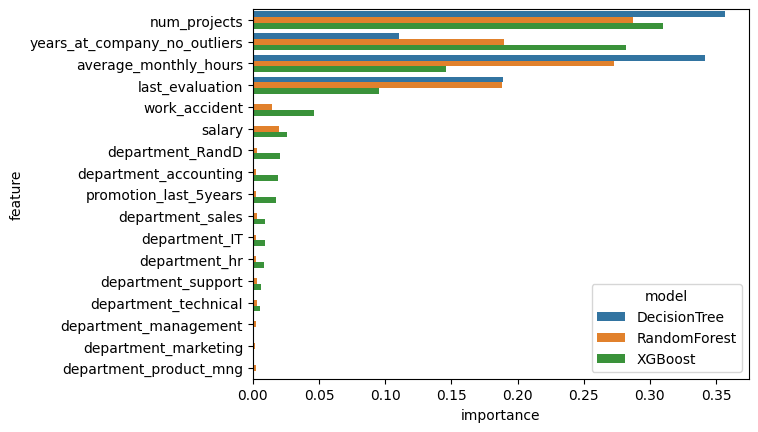

In [ ]:
df_imp = get_importances_df(
    [dt_cv, rf_cv, xgb_cv],
     ['DecisionTree', 'RandomForest', 'XGBoost'],
    X.columns
).sort_values('XGBoost', ascending=False)
df_melt = df_imp.melt(id_vars='feature', var_name='model', value_name='importance')

sns.barplot(data=df_melt, x='importance', y='feature', hue='model')

# fig, ax = plt.subplots(figsize=(12, 7), nrows=2, ncols=2, sharex=True, constrained_layout=True)
# plot_cv_importance(dt_cv, X.columns, ax[0, 0])
# plot_cv_importance(rf_cv, X.columns, ax[0, 1])
# plot_cv_importance(xgb_cv, X.columns, ax[1, 0])

# labels = ['DecisionTree', 'RandomForest', 'XGBoost']
# for ax_, label in zip(ax.flatten(), labels):
#     ax_.text(0.5, 0.05, label, ha='center', va='bottom', transform=ax_.transAxes)

# ax[1, 1].set_axis_off()
plt.show()

`num_projects`, `years_at_company`, and `average_monthly_hours` are contributing the most to all the models. The leave rate within each department was fairly similar and `department` doesn't contribute much to any of these models, so we'll drop it.

In [ ]:
scores = get_scores(['XGBoost_test'], [xgb_cv], X_test, y_test, refit, results=scores)
scores

,model,acc,prec,recall,f1,roc_auc
0,XGBoost,0.978315,0.945876,0.922111,0.933842,0.982805
1,DecisionTree,0.972894,0.913151,0.924623,0.918851,0.973689
2,RandomForest,0.973728,0.951482,0.886935,0.918075,0.977609
3,XGBoost_test,0.970404,0.907731,0.914573,0.911139,0.974650
4,LogisticRegression,0.688073,0.304688,0.685930,0.421947,0.747222


# Second Iteration

With the exception of the logistic regression model which performs poorly here, the scores are all very high. There may be some data leakage, e.g., from `average_monthly_hours`. If an employee has already decided to quit or has been identified as someone to be fired, they may take on fewer hours. Since a significant number of employees who left had high hours, we will assume that part of the reason they left was due to being overworked. `average_monthly_hours` will be converted into `overworked`.

In [ ]:
print(
    f"The mean and median average monthly hours are {df1['average_monthly_hours'].mean():.1f}"
    f" and {df1['average_monthly_hours'].median():.1f}."
)
df1.groupby('left')['average_monthly_hours'].mean().reset_index().round(1)

The mean and median average monthly hours are 200.5 and 200.0.


,left,average_monthly_hours
0,0,198.9
1,1,208.2


Assuming an employee works 40 hours per week for ~50 weeks per year, their average monthly hours should be about 167 hours per month. If an employee is working 180 hours or more per month, we'll consider them being overworked.

The total average and median are both 200 hours for this set of employees, meaning that a lot of employees are working more than an average person.

In [ ]:
df1['overworked'] = (df1['average_monthly_hours'] > 180).astype(int)

In [ ]:
X2 = df1.drop(['left', 'satisfaction', 'department', 'years_at_company', 'average_monthly_hours'], axis=1)
y2 = df1['left']

X_train_, X_test2, y_train_, y_test2 = train_test_split(X2, y2, test_size=0.2, stratify=y, random_state=12)
X_train2, X_valid2, y_train2, y_valid2 = train_test_split(
    X_train_, y_train_, test_size=0.25, stratify=y_train_, random_state=12
)
X_train2.head()

,last_evaluation,num_projects,work_accident,promotion_last_5years,years_at_company_no_outliers,salary,overworked
5938,0.59,5,1,0,3,1,1
6443,0.56,3,0,0,2,1,0
1845,0.56,2,0,0,3,0,0
1813,0.81,6,0,0,4,0,1
4464,0.65,5,0,0,2,1,1


## Logistic Regression

In [ ]:
lr_cv2 = LogisticRegressionCV(
    Cs=5, scoring='f1', cv=5, class_weight='balanced', refit=True, max_iter=500, n_jobs=-1, random_state=12
)

In [ ]:
%%time
lr_cv2.fit(X_train2, y_train2)

CPU times: user 36.2 ms, sys: 10.1 ms, total: 46.4 ms
Wall time: 323 ms


LogisticRegressionCV(Cs=5, class_weight='balanced', cv=5, max_iter=500,
                     n_jobs=-1, random_state=12, scoring='f1')

## Decision Tree

In [ ]:
dt_cv2 = GridSearchCV(dt, param_grid=dt_params, scoring=scoring, cv=5, refit=refit, n_jobs=-1)

In [ ]:
%%time
dt_cv2.fit(X_train2, y_train2)

CPU times: user 107 ms, sys: 54.5 ms, total: 161 ms
Wall time: 1.22 s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=12), n_jobs=-1,
             param_grid={'max_depth': [3, 5, None], 'min_samples_leaf': [1, 3],
                         'min_samples_split': [2, 4]},
             refit='f1',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [ ]:
print(dt_cv2.best_params_)
print(dt_cv2.best_score_)

{'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 2}
0.8805597505242746


## Random Forest

In [ ]:
rf_cv2 = GridSearchCV(rf, param_grid=rf_params, scoring=scoring, cv=5, refit=refit, n_jobs=-1)

In [ ]:
%%time
rf_cv2.fit(X_train2, y_train2)

CPU times: user 4.15 s, sys: 622 ms, total: 4.77 s
Wall time: 4min 47s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=12), n_jobs=-1,
             param_grid={'max_depth': [3, 5, None], 'max_features': [1, 2],
                         'min_samples_leaf': [1, 3],
                         'min_samples_split': [2, 4],
                         'n_estimators': [300, 500]},
             refit='f1',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [ ]:
print(rf_cv2.best_params_)
print(rf_cv2.best_score_)

{'max_depth': None, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 300}
0.8947787192964759


## XGBoost

In [ ]:
xgb_cv2 = GridSearchCV(xgb, param_grid=xgb_params, scoring=scoring, cv=5, refit=refit, n_jobs=-1)

In [ ]:
%%time
xgb_cv2.fit(X_train2, y_train2)

CPU times: user 813 ms, sys: 67 ms, total: 881 ms
Wall time: 15 s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=12, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.03, 0.3],
                         'max_depth': [3, None], 'n_estimators': [300, 500]},
             refit='f1',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [ ]:
print(xgb_cv2.best_params_)
print(xgb_cv2.best_score_)

{'learning_rate': 0.01, 'max_depth': None, 'n_estimators': 300}
0.8961546070534349


## Scoring

In [ ]:
scores = get_scores(
    ['LogisticRegression2', 'DecisionTree2', 'RandomForest2', 'XGBoost2'],
    [lr_cv2, dt_cv2.best_estimator_, rf_cv2.best_estimator_, xgb_cv2.best_estimator_],
    X_valid2,
    y_valid2,
    refit,
    results=scores,
)
scores

,model,acc,prec,recall,f1,roc_auc
0,XGBoost,0.978315,0.945876,0.922111,0.933842,0.982805
1,DecisionTree,0.972894,0.913151,0.924623,0.918851,0.973689
2,RandomForest,0.973728,0.951482,0.886935,0.918075,0.977609
3,XGBoost_test,0.970404,0.907731,0.914573,0.911139,0.974650
4,XGBoost2,0.969141,0.905000,0.909548,0.907268,0.976500
5,RandomForest2,0.969558,0.917738,0.896985,0.907243,0.973518
6,DecisionTree2,0.964554,0.902314,0.881910,0.891995,0.947903
7,LogisticRegression2,0.732277,0.343990,0.675879,0.455932,0.776131
8,LogisticRegression,0.688073,0.304688,0.685930,0.421947,0.747222


As expected, the scores are not as high as before. However, this model might be more generalizable across employees. Another consideration is `last_evaluation`. This may be another source of data leakage if employees are fired based on evaluation scores. It's also unclear how often evaluations are performed, so scores may not be available for some employees or not up to date.

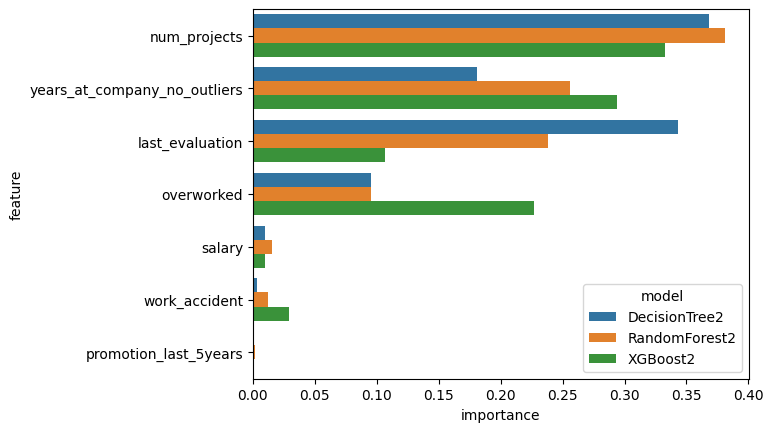

In [ ]:
df_imp = get_importances_df(
    [dt_cv2, rf_cv2, xgb_cv2], ['DecisionTree2', 'RandomForest2', 'XGBoost2'], X2.columns
).sort_values('RandomForest2', ascending=False)
df_melt = df_imp.melt(id_vars='feature', var_name='model', value_name='importance')

sns.barplot(data=df_melt, x='importance', y='feature', hue='model')
plt.show()

# Final Iteration

As a final test, we'll trying dropping `last_evaluation`.

In [ ]:
X3 = df1.drop(
    ['left', 'satisfaction', 'department', 'years_at_company', 'average_monthly_hours', 'last_evaluation'],
    axis=1
)
y3 = df1['left']

X_train_, X_test3, y_train_, y_test3 = train_test_split(X3, y3, test_size=0.2, stratify=y, random_state=12)
X_train3, X_valid3, y_train3, y_valid3 = train_test_split(
    X_train_, y_train_, test_size=0.25, stratify=y_train_, random_state=12
)
X_train3.head()

,num_projects,work_accident,promotion_last_5years,years_at_company_no_outliers,salary,overworked
5938,5,1,0,3,1,1
6443,3,0,0,2,1,0
1845,2,0,0,3,0,0
1813,6,0,0,4,0,1
4464,5,0,0,2,1,1


## Logistic Regression

In [ ]:
lr_cv3 = LogisticRegressionCV(
    Cs=5, scoring='f1', cv=5, class_weight='balanced', refit=True, max_iter=500, n_jobs=-1, random_state=12
)

In [ ]:
%%time
lr_cv3.fit(X_train3, y_train3)

CPU times: user 37.2 ms, sys: 17.6 ms, total: 54.8 ms
Wall time: 315 ms


LogisticRegressionCV(Cs=5, class_weight='balanced', cv=5, max_iter=500,
                     n_jobs=-1, random_state=12, scoring='f1')

## Decision Tree

In [ ]:
dt_cv3 = GridSearchCV(dt, param_grid=dt_params, scoring=scoring, cv=5, refit=refit, n_jobs=-1)

In [ ]:
%%time
dt_cv3.fit(X_train3, y_train3)

CPU times: user 113 ms, sys: 78.1 ms, total: 191 ms
Wall time: 1.63 s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=12), n_jobs=-1,
             param_grid={'max_depth': [3, 5, None], 'min_samples_leaf': [1, 3],
                         'min_samples_split': [2, 4]},
             refit='f1',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

## Random Forest

In [ ]:
rf_cv3 = GridSearchCV(rf, param_grid=rf_params, scoring=scoring, cv=5, refit=refit, n_jobs=-1)

In [ ]:
%%time
rf_cv3.fit(X_train3, y_train3)

CPU times: user 3.85 s, sys: 602 ms, total: 4.45 s
Wall time: 4min 24s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=12), n_jobs=-1,
             param_grid={'max_depth': [3, 5, None], 'max_features': [1, 2],
                         'min_samples_leaf': [1, 3],
                         'min_samples_split': [2, 4],
                         'n_estimators': [300, 500]},
             refit='f1',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [ ]:
print(rf_cv3.best_params_)
print(rf_cv3.best_score_)

{'max_depth': None, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 300}
0.8288234381953188


## XGBoost

In [ ]:
xgb_cv3 = GridSearchCV(xgb, param_grid=xgb_params, scoring=scoring, cv=5, refit=refit, n_jobs=-1)

In [ ]:
%%time
xgb_cv3.fit(X_train3, y_train3)

CPU times: user 774 ms, sys: 50.7 ms, total: 825 ms
Wall time: 13.8 s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=12, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.03, 0.3],
                         'max_depth': [3, None], 'n_estimators': [300, 500]},
             refit='f1',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [ ]:
print(xgb_cv3.best_params_)
print(xgb_cv3.best_score_)

{'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 500}
0.8333200818495385


## Scoring

In [ ]:
scores = get_scores(
    ['LogisticRegression3', 'DecisionTree3', 'RandomForest3', 'XGBoost3'],
    [lr_cv3, dt_cv3.best_estimator_, rf_cv3.best_estimator_, xgb_cv3.best_estimator_],
    X_valid3,
    y_valid3,
    refit,
    results=scores,
)
scores

,model,acc,prec,recall,f1,roc_auc
0,XGBoost,0.978315,0.945876,0.922111,0.933842,0.982805
1,DecisionTree,0.972894,0.913151,0.924623,0.918851,0.973689
2,RandomForest,0.973728,0.951482,0.886935,0.918075,0.977609
3,XGBoost_test,0.970404,0.907731,0.914573,0.911139,0.974650
4,XGBoost2,0.969141,0.905000,0.909548,0.907268,0.976500
5,RandomForest2,0.969558,0.917738,0.896985,0.907243,0.973518
6,DecisionTree2,0.964554,0.902314,0.881910,0.891995,0.947903
7,RandomForest3,0.945371,0.804100,0.886935,0.843489,0.963602
8,DecisionTree3,0.945371,0.811189,0.874372,0.841596,0.951967
9,XGBoost3,0.944537,0.807425,0.874372,0.839566,0.965822


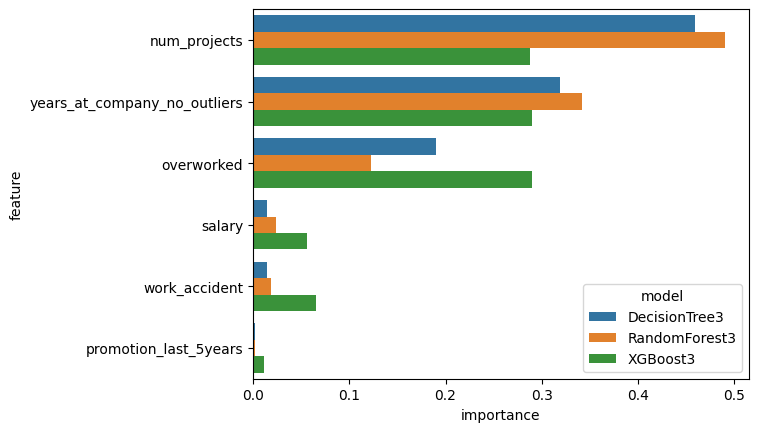

In [ ]:
df_imp = get_importances_df(
    [dt_cv3, rf_cv3, xgb_cv3], ['DecisionTree3', 'RandomForest3', 'XGBoost3'], X3.columns
).sort_values('RandomForest3', ascending=False)
df_melt = df_imp.melt(id_vars='feature', var_name='model', value_name='importance')

sns.barplot(data=df_melt, x='importance', y='feature', hue='model')
plt.show()

# Final Model

The XGBoost classifier overall worked the best, so we'll test this as our final model.

In [ ]:
y_pred = rf_cv3.best_estimator_.predict(X_test3)

In [ ]:
get_scores(['RandomForest3_test'], [rf_cv3], X_test3, y_test3, refit, results=scores)

,model,acc,prec,recall,f1,roc_auc
0,XGBoost,0.978315,0.945876,0.922111,0.933842,0.982805
1,DecisionTree,0.972894,0.913151,0.924623,0.918851,0.973689
2,RandomForest,0.973728,0.951482,0.886935,0.918075,0.977609
3,XGBoost_test,0.970404,0.907731,0.914573,0.911139,0.974650
4,XGBoost2,0.969141,0.905000,0.909548,0.907268,0.976500
5,RandomForest2,0.969558,0.917738,0.896985,0.907243,0.973518
6,DecisionTree2,0.964554,0.902314,0.881910,0.891995,0.947903
7,RandomForest3,0.945371,0.804100,0.886935,0.843489,0.963602
8,DecisionTree3,0.945371,0.811189,0.874372,0.841596,0.951967
9,XGBoost3,0.944537,0.807425,0.874372,0.839566,0.965822


In [ ]:
print(metrics.classification_report(y_test3, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      2001
           1       0.81      0.87      0.84       398

    accuracy                           0.94      2399
   macro avg       0.89      0.92      0.90      2399
weighted avg       0.95      0.94      0.95      2399



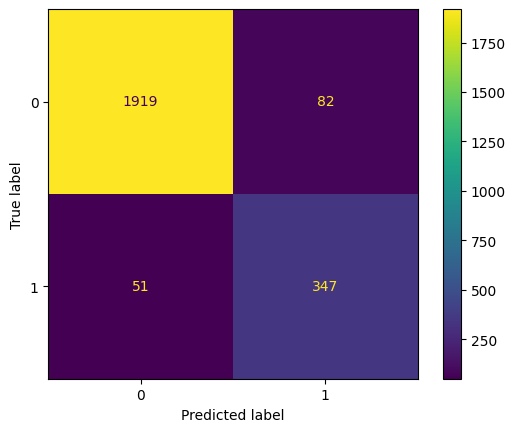

In [ ]:
cm = metrics.confusion_matrix(y_test3, y_pred)
metrics.ConfusionMatrixDisplay(cm, display_labels=rf_cv3.best_estimator_.classes_).plot()

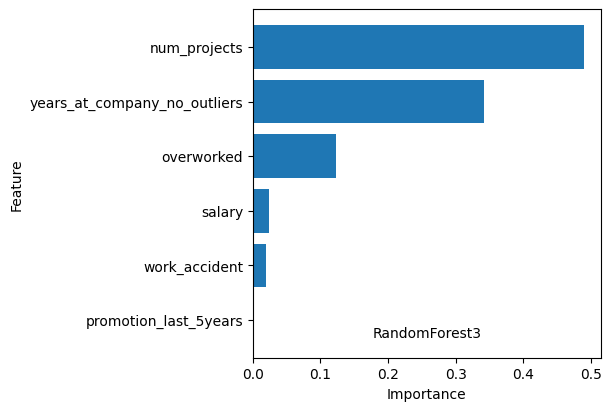

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)
plot_cv_importance(rf_cv3, X3.columns, ax)
ax.text(0.5, 0.05, 'RandomForest3', ha='center', va='bottom', transform=ax.transAxes)
plt.show()

According to the model, the biggest factors that lead to an employee leaving are their workload, whether they're overworked, and how long they've been with the company. If the company wants to reduce employee turnover, they will need to make adjustments to alleviate the high number of hours and projects that employees are being tasked with.